# Results for experiments over KDDCup dataset

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import pandas
import pickle
import os
import re

from sklearn import metrics

In [2]:
import seaborn
seaborn.set_style('white')

In [3]:
def get_runs(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'prediction' in run_prediction]

def get_learning(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'performance' in run_prediction]

In [6]:
def base_metrics_df():
    return pandas.DataFrame(columns=['Experiment', 'Run',
                                     'AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

In [80]:
def read_file_metrics(filename):
    """Returns a DataFrame with values AUC, RMSE, APS, Accuracy, R2 Score"""
    results = []
    ignored_sequences = 0
    with open(filename, 'rb') as prediction_file:
        true, predicted = pickle.load(prediction_file)
    try:
        results.append([metrics.roc_auc_score(true, predicted)])
    except ValueError:
        ignored_sequences += 1
        results.append([numpy.nan])
    results[-1].append(metrics.mean_squared_error(true, predicted)**0.5)
    results[-1].append(metrics.average_precision_score(true, predicted))
    results[-1].append(metrics.accuracy_score(true, numpy.where(predicted > 0.5, 1, 0)))
    results[-1].append(metrics.r2_score(true, predicted))
    if ignored_sequences > 0:    
        print('{} sequences with only one class, ignoring.'.format(ignored_sequences))
    return pandas.DataFrame(results, columns=['AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

In [82]:
def read_metrics(dirnames):
    metrics_dfs = []
    for dirname in dirnames:
        for filename in get_runs(dirname):
            file_metrics = read_file_metrics(os.path.join(dirname, filename))
            file_metrics['Experiment'] = dirname[-16:]
            file_metrics['Run'] = re.search('.*run(\d+).*', filename).group(1)
            metrics_dfs.append(file_metrics)
    return pandas.concat(metrics_dfs, ignore_index=True).set_index(['Experiment', 'Run'])

## Experiments with LSTM model

In [18]:
LSTM_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-09-35/',
]

## Learning curves

In [75]:
def read_performances(dirnames):
    results = {}
    for dirname in reversed(dirnames):
        dataframes = []
        for filename in get_learning(dirname):
            with open(os.path.join(dirname, filename), 'rb') as performance_file:
                train, validation = pickle.load(performance_file)
            train = pandas.DataFrame(train, columns=['epoch', 'mse'], dtype=numpy.float32)
            validation = pandas.DataFrame(validation, columns=['epoch', 'mse'], dtype=numpy.float32)
            train['Dataset'] = 'train'
            train['Run'] = re.search('.*run(\d+).*', filename).group(1)
            validation['Dataset'] = 'validation'
            validation['Run'] = re.search('.*run(\d+).*', filename).group(1)
            dataframes.append(pandas.concat([train, validation]))
        if len(dataframes) > 0:
            results[dirname] = pandas.concat(dataframes) # train.join(validation, lsuffix='_t', rsuffix='_v')
    return results

def graphic_performances(train_performances):
    for dirname, performance_dataframe in train_performances.items():
        print(dirname)
        performance_dataframe['epoch'] = performance_dataframe.epoch.astype(numpy.int)
        grid = seaborn.FacetGrid(data=performance_dataframe,
                                 col='Run', despine=True, ylim=[0, 0.2], aspect=1.5, col_wrap=2,
                                 palette='colorblind')
        mapped = grid.map(seaborn.pointplot, 'epoch', 'mse', 'Dataset').add_legend()

In [62]:
lstm_performances = read_performances(LSTM_EXPERIMENTS_DIRS)

/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-09-35/


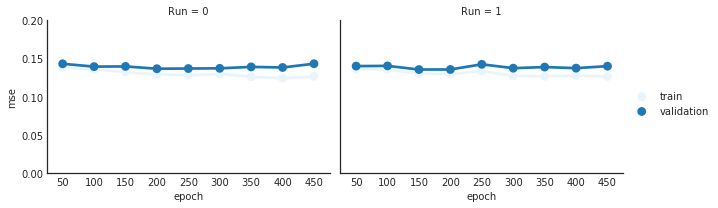

In [76]:
graphic_performances(lstm_performances)

## Performance Metrics

In [83]:
lstm_metrics = read_metrics(LSTM_EXPERIMENTS_DIRS)

In [84]:
lstm_metrics

AUC      RMSE       APS  Accuracy        R2
Experiment       Run                                                  
/17-12-21-09-35/ 0    0.779784  0.390246  0.848661  0.797692  0.269396
                 1    0.794248  0.385075  0.864748  0.792308  0.286474

## Experiments with Embedde LSTM model

In [23]:
EMBEDDING_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-51/',
    '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-59/',
    '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-10-02/',
]

## Learning curves

In [24]:
embedding_performances = read_performances(EMBEDDING_EXPERIMENTS_DIRS)

/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-10-02/
/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-59/
/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-51/


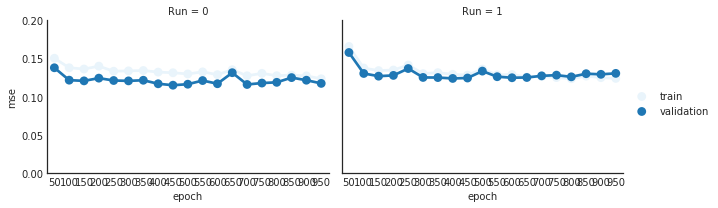

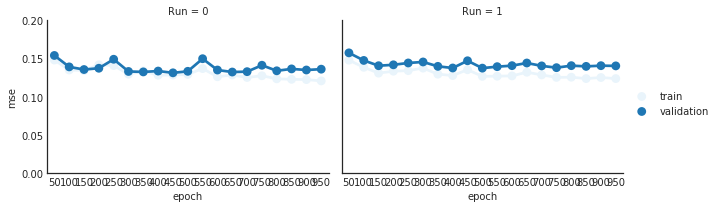

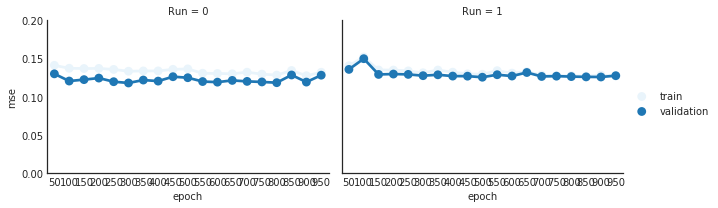

In [77]:
graphic_performances(embedding_performances)

## Performance Metrics

In [86]:
embedding_metrics = read_metrics(EMBEDDING_EXPERIMENTS_DIRS)

In [87]:
embedding_metrics

AUC      RMSE       APS  Accuracy        R2
Experiment       Run                                                  
/17-12-21-09-51/ 0    0.873192  0.361549  0.909570  0.820588  0.429753
                 1    0.877666  0.358644  0.915204  0.828824  0.438045
/17-12-21-09-59/ 0    0.868660  0.366662  0.907280  0.828235  0.413943
                 1    0.878163  0.361312  0.914966  0.823529  0.428796
/17-12-21-10-02/ 0    0.869597  0.365838  0.905694  0.821765  0.414838
                 1    0.875865  0.360364  0.915491  0.824706  0.432643